# How often do Afterpay transactions attract late fees? (Part 4)
> Afterpay has just released it's 2020 annual reprot, and it includes 2 new, and exciting pieces of information.

- toc: true 
- badges: true
- comments: true
- categories: [Bayesian,PyMC3,Finance,Monte Carlo Simulation,Afterpay]
    
- image: images/2020-08-27-Afterpay-Customer-Defaults-Part-4/header.png

## Introduction

*Afterpay* has just released it's [FY20 Annual Results](https://www.afterpay.com/attachment/245/show). I've had a quick skim through it, and there were two statistics that caught my eye.

![Late Fees](../images/2020-08-28-Afterpay-Customer-Defaults-Part-4/late_fees.png)

This is exactly the information we tried to infer over the last couple of posts, and now we have some real ground truth to compare to!

At the end of the [last post](https://cgcooke.github.io/Blog/bayesian/pymc3/finance/monte%20carlo%20simulation/afterpay/2020/08/22/Afterpay-Customer-Defaults-Part-3.html), I finished by saying that: "We find that between 3 and 12% of transactions are attracting late fees.  Overall, our best estimate is 7%." Hence I'm pretty happy that the true value of ±10%, is within the bounds of what we expected. 

now let's take this new piece of information, and try to infer more about the underlying, unobserved parameters in our model.

> Important:  Obviously I need a disclaimer. If you use anything I say as the basis for any decision, financial or otherwise, you are an idiot.



Let's think about this at a high level.

We now know that approximately 10% of purchases had one or more payments that were late.

This 10% of purchases, represents approximately 10% of payments.

Hence, on average, approximately 30% (±5% points) of payments are late within this cohort.

There are 4 payments, at least one of which is late.


## The Model

Let's model this out in code, the variable names get quite verbose!

In the case of both "percentage_of_purchases_incuring_late_fees" and "ercentage_of_all_transactions_incuring_late_fees", I'm modelling them as a uniform distribution. This is because *Afterpay* is rounding both of them to the nearest integer.


In [1]:
%matplotlib inline
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns

plt.rcParams["figure.figsize"] = (10,10)
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
with pm.Model() as model:
    percentage_of_purchases_incuring_late_fees = pm.Uniform('percentage_of_purchases_incuring_late_fees', lower=9.5, upper=10.49)
    percentage_of_all_transactions_incuring_late_fees = pm.Uniform('percentage_of_all_transactions_incuring_late_fees', lower=2.5, upper = 3.49)
    percentage_of_late_purchase_transactions_incuring_late_fees =  pm.Deterministic('percentage_of_late_purchase_transactions_incuring_late_fees', 100 * percentage_of_all_transactions_incuring_late_fees / percentage_of_purchases_incuring_late_fees)
    average_num_late_purchase_transactions_incuring_late_fees = pm.Deterministic('average_num_late_purchase_transactions_incuring_late_fees',4 * percentage_of_late_purchase_transactions_incuring_late_fees / 100)

By looking at the graph, we can see that the two pieces of information that we have been provided, are used in turn to create a distribution of "percentage_of_late_purchase_transactions_incuring_late_fees".

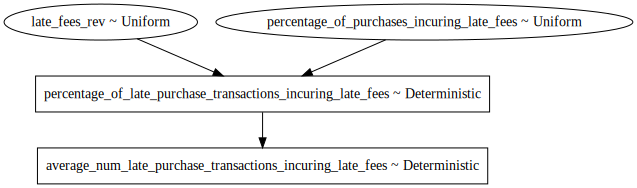

In [6]:
pm.model_to_graphviz(model)

Now we can draw samples from our model.

In [3]:
with model:
    samples = pm.sample_prior_predictive(samples=50_000, random_seed=0)

## Results

We can now visualise the distribution of the number of late transactions per purchase, given that there is one or more late fees. We can notice, that because we have taken the rounding into account, our model shows that sometimes there are less than 1 late payment, per purchase. Obviously this is impossible in practice!

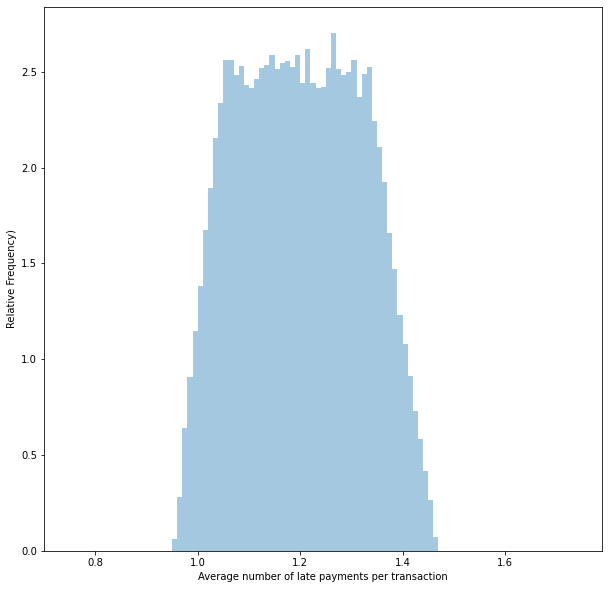

In [4]:
samples = samples['average_num_late_purchase_transactions_incuring_late_fees']

sns.distplot(samples,bins=np.arange(0.75,1.75,0.01),kde=False,norm_hist=True)
plt.xlabel('Average number of late payments per transaction')
plt.ylabel('Relative Frequency')
plt.show()

Finally we can make one last modelling assumption, to help 

Given that one of the 4 payments was late, we might assume that each of the 3 equally, and independently likely to be late as well. IE, we are using the Binomial distribution to model late payments.

Binomial($n$,$p$), where $n$ is 3, and we want to find $p$.

Given the mean of this distribution is $n\times p$, we can find $p = \frac{(samples - 1)}{3}$.


In [ ]:
probability_of_late_payment_per_payment = 100 * (samples - 1) /3.0

Putting this all together, we can now can find a distribution for $p$.

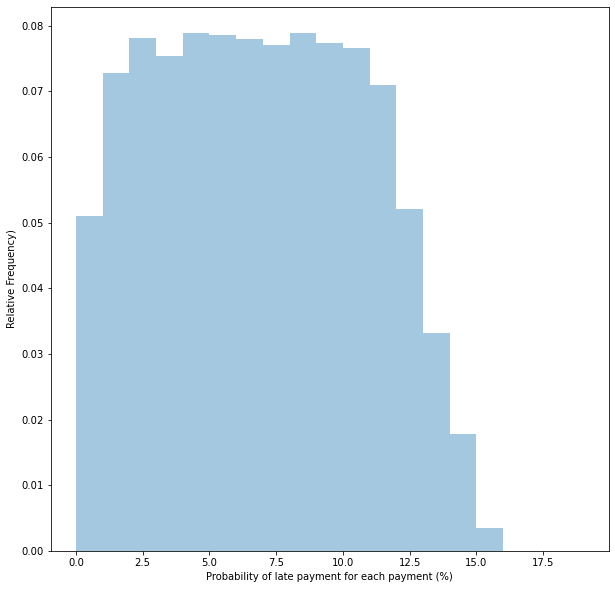

In [5]:
sns.distplot(probability_of_late_payment_per_payment,bins=np.arange(0,20),kde=False,norm_hist=True)
plt.xlabel('Probability of late payment for each payment (%)')
plt.ylabel('Relative Frequency')
plt.show()

In [8]:
pm.summary(probability_of_late_payment_per_payment)

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 50000), minimum_shape: (chains=2, draws=4)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,6.673,3.994,-0.296,13.347,0.018,0.013,48704.0,48704.0,48903.0,47982.0,NaN


## Conclusion

Based on what *Afterpay* has publicly released, we now a more concrete perspective on how often people pay late.

What I found quite interesting, was that while there is a ±10% chance of someone having at least one late payment on any given purchase, the probability of any individual subsequent payment being late is quite low. It's at most ±13%, with a best guess of 7%. 
